<a href="https://colab.research.google.com/github/ekaratnida/Automated_Tools-/blob/main/Module3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Forecasting Using FbProphet

In [1]:
#!pip install pystan
#!pip install fbprophet
#!pip install statsmodels
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

%matplotlib inline
# check prophet version
# print version number


       Month  Sales
0    1960-01   6550
1    1960-02   8728
2    1960-03  12026
3    1960-04  14395
4    1960-05  14587
..       ...    ...
103  1968-08  16722
104  1968-09  14385
105  1968-10  21342
106  1968-11  17180
107  1968-12  14577

[108 rows x 2 columns]


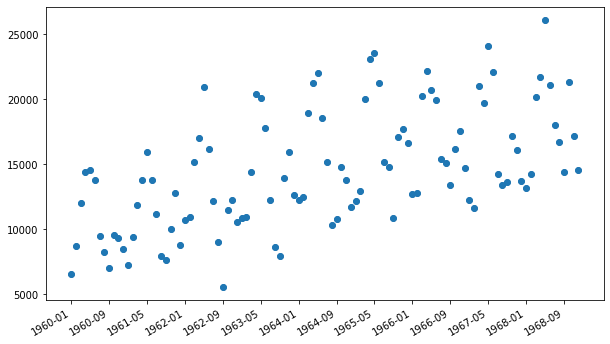

In [2]:
# load data
path = 'https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/master/Dataset/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)
print(df)

x = df['Month']
y = df['Sales']

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(x, y, s = 30, color = '#336699', alpha = 0.75)
ax.set_xticks(ax.get_xticks()[::8])
fig.autofmt_xdate()

plt.scatter(x,y)


In [3]:
df1 = df.copy()
df1.set_index('Month',inplace=True)
df1.index=pd.to_datetime(df1.index)
df1.dropna(inplace=True)
#Show new df after changing the index
print(df1)

            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587
...           ...
1968-08-01  16722
1968-09-01  14385
1968-10-01  21342
1968-11-01  17180
1968-12-01  14577

[108 rows x 1 columns]


##Decomposition

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


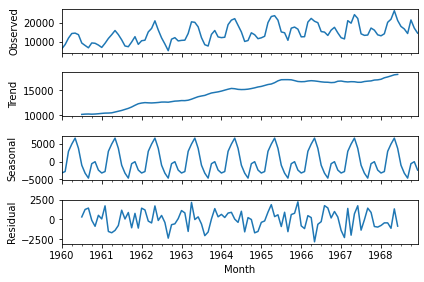

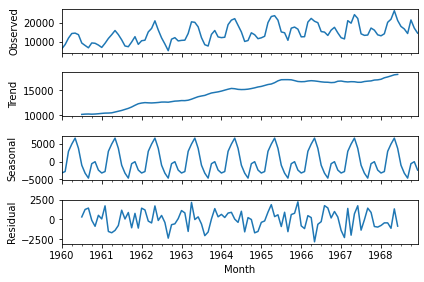

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df1['Sales'],  model='additive')
result.plot()

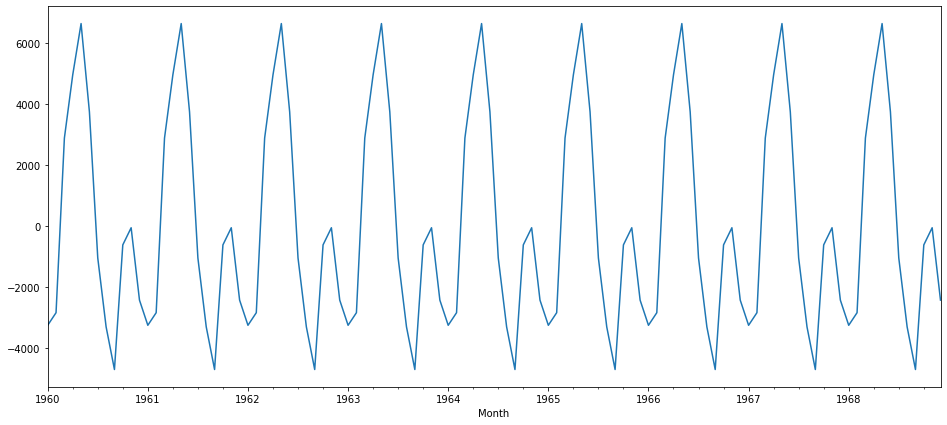

In [5]:
plt.figure(figsize = (16,7))
result.seasonal.plot();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


1968-01-01    12086.532481
1968-02-01    12641.281723
1968-03-01    16334.397866
1968-04-01    21202.836242
1968-05-01    21153.083008
1968-06-01    23798.976324
1968-07-01    18800.926618
1968-08-01    17029.384896
1968-09-01    17657.407384
1968-10-01    17828.765732
1968-11-01    22127.063299
1968-12-01    17654.539751
Freq: MS, Name: ARIMA Predictions, dtype: float64


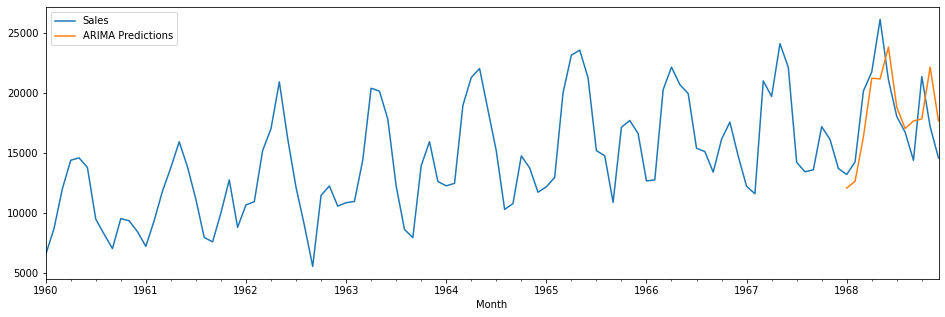

In [6]:
# arima
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
# Train model
arima_model = ARIMA(df1['Sales'], order=(5,1,0)) #, order = (0,1,2), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()


#Prediction
arima_pred = arima_result.predict(start = len(df1)-12, end = len(df1)-1, typ="levels").rename("ARIMA Predictions")
print(arima_pred)

df1['Sales'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [7]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
#Model Evaluation
arima_rmse_error = rmse(df1['Sales'][-12:], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df1['Sales'][-12:].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 9010705.639751753
RMSE Error: 3001.783743002109
Mean: 18228.166666666668


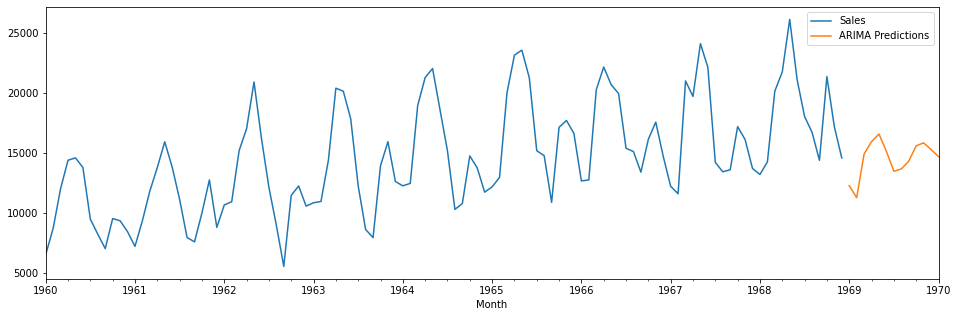

In [8]:
#Prediction
arima_pred = arima_result.predict(start = len(df1), end = len(df1)+12, typ="levels").rename("ARIMA Predictions")
arima_pred

df1['Sales'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

### **Prophet**









In [9]:
# prepare expected column names
df2 = df.copy()
df2.columns = ['ds', 'y']

# define the model
model = Prophet()

# fit model
model.fit(df2)



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### **In sample forecast**

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14334.737769  12793.091682  15930.670506
1 1968-02-01  14905.955964  13294.330828  16649.920324
2 1968-03-01  20842.150502  19273.909291  22356.163340
3 1968-04-01  22870.095215  21322.215016  24419.893921
4 1968-05-01  24176.211162  22483.254943  25656.363370


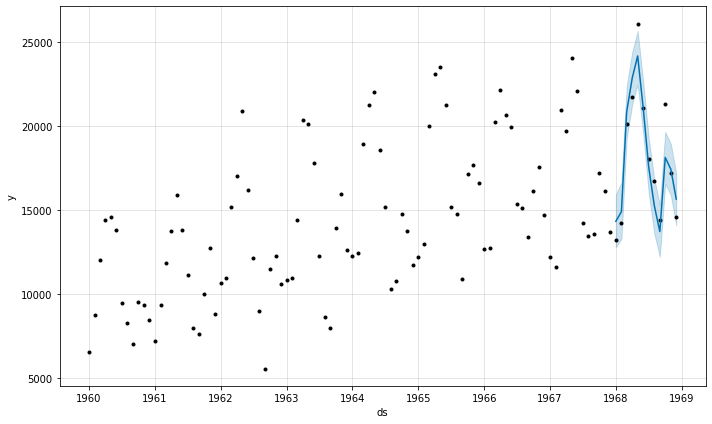

In [10]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
 
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()



In [11]:
prophet_rmse_error = rmse(df2['y'][-12:], forecast['yhat'])
prophet_mse_error = prophet_rmse_error**2
mean_value = df2['y'][-13:-1].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 1783395.1844450273
RMSE Error: 1335.4381994106006
Mean: 18156.166666666668


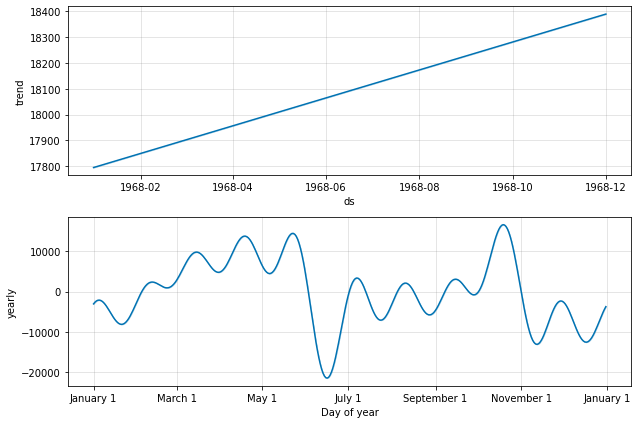

In [12]:
fig1 = model.plot_components(forecast)

### **Out of sample forecast**

          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15375.960093  13782.507663  17049.043846
1 1969-02-01  16142.271673  14530.971396  17746.990514
2 1969-03-01  21351.832640  19735.834384  22975.598124
3 1969-04-01  23477.889811  21896.440720  24988.872841
4 1969-05-01  24988.440907  23358.148492  26601.380906


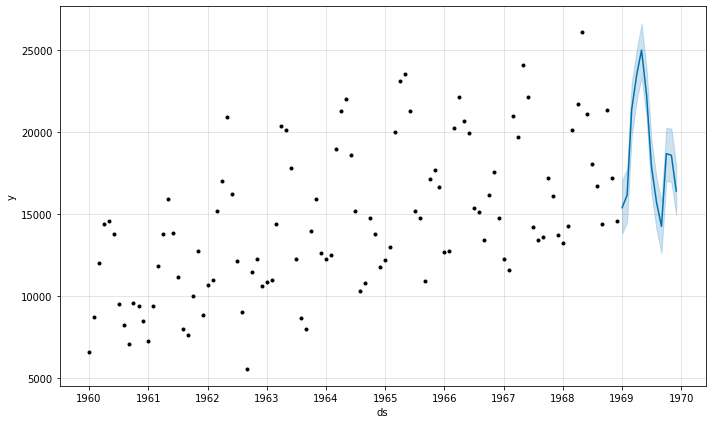

In [13]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1969-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

#Stock data

In [14]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
import pandas_datareader as web
import datetime
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 6, 30)
df3 = web.DataReader("PTT.BK", 'yahoo', start, end)
df3.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,45.50,44.00,44.25,45.50,59084700.0,41.030182
2020-01-03,47.00,46.00,46.25,46.50,147370600.0,41.931942
2020-01-06,47.75,46.50,47.25,47.00,91026800.0,42.382824
2020-01-07,47.25,46.25,47.25,47.25,60059600.0,42.608265
2020-01-08,47.75,46.75,47.50,46.75,57759900.0,42.157387


# Crypto data

In [7]:
# Import libraries
import json
import requests

# Defining Binance API URL
key = "https://api.binance.com/api/v3/ticker/price?symbol="

# Making list for multiple crypto's
currencies = ["BTCUSDT", "DOGEUSDT", "LTCUSDT"]
j = 0

# running loop to print all crypto prices
for i in currencies:
	
	# completing API for request
	url = key+currencies[j]
	data = requests.get(url)
	data = data.json()
	j = j+1
	print(f"{data['symbol']} price is {data['price']}")


BTCUSDT price is 34584.58000000
DOGEUSDT price is 0.12560000
LTCUSDT price is 93.70000000
